# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=45,
        fold=1,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_14-39-31/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191567 [00:00<?, ?it/s]

  0%|          | 0/21461 [00:00<?, ?it/s]

  0%|          | 0/53624 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191567 [00:00<?, ?it/s]

  0%|          | 0/53624 [00:00<?, ?it/s]

  0%|          | 0/21461 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.5641 | MulticlassF1Score=0.0248
Batch-30 : CrossEntropyLoss=2.4824 | MulticlassF1Score=0.1113
Batch-45 : CrossEntropyLoss=2.4920 | MulticlassF1Score=0.1620
Batch-60 : CrossEntropyLoss=2.4951 | MulticlassF1Score=0.1867
Batch-75 : CrossEntropyLoss=2.4815 | MulticlassF1Score=0.2001
Batch-90 : CrossEntropyLoss=2.4789 | MulticlassF1Score=0.2101
Batch-105: CrossEntropyLoss=2.5231 | MulticlassF1Score=0.2169
Batch-120: CrossEntropyLoss=2.4639 | MulticlassF1Score=0.2248
Batch-135: CrossEntropyLoss=2.4582 | MulticlassF1Score=0.2391
Batch-150: CrossEntropyLoss=2.4559 | MulticlassF1Score=0.2523
Batch-165: CrossEntropyLoss=2.4483 | MulticlassF1Score=0.2637
Batch-180: CrossEntropyLoss=2.4357 | MulticlassF1Score=0.2730
Batch-195: CrossEntropyLoss=2.4314 | MulticlassF1Score=0.2810
Batch-210: CrossEntropyLoss=2.4265 | MulticlassF1Score=0.2874
Batch-225: CrossEntropyLoss=2.4153 | MulticlassF1Score=0.2938
Batch-226: CrossEntropyLoss=2.4353 | MulticlassF1Score=0.2940

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4523 | MulticlassF1Score=0.3752
Batch-30 : CrossEntropyLoss=2.4340 | MulticlassF1Score=0.3786
Batch-45 : CrossEntropyLoss=2.4634 | MulticlassF1Score=0.3770
Batch-60 : CrossEntropyLoss=2.4633 | MulticlassF1Score=0.3774
Batch-63 : CrossEntropyLoss=2.4509 | MulticlassF1Score=0.3767

Training   : Mean CrossEntropyLoss = 2.4751 | Mean MulticlassF1Score = 0.2078
Validation : Mean CrossEntropyLoss = 2.4422 | Mean MulticlassF1Score = 0.3776

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4189 | MulticlassF1Score=0.3688
Batch-30 : CrossEntropyLoss=2.4336 | MulticlassF1Score=0.3716
Batch-45 : CrossEntropyLoss=2.4429 | MulticlassF1Score=0.3749
Batch-60 : CrossEntropyLoss=2.4221 | MulticlassF1Score=0.3787
Batch-75 : CrossEntropyLoss=2.4860 | MulticlassF1Score=0.3785
Batch-90 : CrossEntropyLoss=2.4358 | MulticlassF1Score=0.3798
Batch-105: CrossEntropyLoss=2.4371 | MulticlassF1Score=0.3790
Batch-120: CrossEntropyLoss=2.4403 | MulticlassF1Score=0.3798
Batch-135: CrossEntropyLoss=2.4068 | MulticlassF1Score=0.3839
Batch-150: CrossEntropyLoss=2.3826 | MulticlassF1Score=0.3941
Batch-165: CrossEntropyLoss=2.3826 | MulticlassF1Score=0.4106
Batch-180: CrossEntropyLoss=2.3604 | MulticlassF1Score=0.4249
Batch-195: CrossEntropyLoss=2.3785 | MulticlassF1Score=0.4379
Batch-210: CrossEntropyLoss=2.3469 | MulticlassF1Score=0.4523
Batch-225: CrossEntropyLoss=2.3395 | MulticlassF1Score=0.4687
Batch-226: CrossEntropyLoss=2.3418 | MulticlassF1Score=0.4694

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3488 | MulticlassF1Score=0.7019
Batch-30 : CrossEntropyLoss=2.3381 | MulticlassF1Score=0.6979
Batch-45 : CrossEntropyLoss=2.3467 | MulticlassF1Score=0.6971
Batch-60 : CrossEntropyLoss=2.3447 | MulticlassF1Score=0.6999
Batch-63 : CrossEntropyLoss=2.3655 | MulticlassF1Score=0.7005

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.4126 | Mean MulticlassF1Score = 0.3961
Validation : Mean CrossEntropyLoss = 2.3433 | Mean MulticlassF1Score = 0.6992

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3459 | MulticlassF1Score=0.6921
Batch-30 : CrossEntropyLoss=2.3437 | MulticlassF1Score=0.6948
Batch-45 : CrossEntropyLoss=2.3403 | MulticlassF1Score=0.7003
Batch-60 : CrossEntropyLoss=2.3383 | MulticlassF1Score=0.7033
Batch-75 : CrossEntropyLoss=2.3386 | MulticlassF1Score=0.7058
Batch-90 : CrossEntropyLoss=2.3297 | MulticlassF1Score=0.7082
Batch-105: CrossEntropyLoss=2.3355 | MulticlassF1Score=0.7098
Batch-120: CrossEntropyLoss=2.3259 | MulticlassF1Score=0.7104
Batch-135: CrossEntropyLoss=2.3385 | MulticlassF1Score=0.7108
Batch-150: CrossEntropyLoss=2.3236 | MulticlassF1Score=0.7123
Batch-165: CrossEntropyLoss=2.3532 | MulticlassF1Score=0.7127
Batch-180: CrossEntropyLoss=2.3200 | MulticlassF1Score=0.7129
Batch-195: CrossEntropyLoss=2.3328 | MulticlassF1Score=0.7133
Batch-210: CrossEntropyLoss=2.3397 | MulticlassF1Score=0.7138
Batch-225: CrossEntropyLoss=2.3340 | MulticlassF1Score=0.7143
Batch-226: CrossEntropyLoss=2.3253 | MulticlassF1Score=0.7144

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3399 | MulticlassF1Score=0.7167
Batch-30 : CrossEntropyLoss=2.3390 | MulticlassF1Score=0.7137
Batch-45 : CrossEntropyLoss=2.3365 | MulticlassF1Score=0.7167
Batch-60 : CrossEntropyLoss=2.3295 | MulticlassF1Score=0.7156
Batch-63 : CrossEntropyLoss=2.3264 | MulticlassF1Score=0.7157

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3366 | Mean MulticlassF1Score = 0.7076
Validation : Mean CrossEntropyLoss = 2.3364 | Mean MulticlassF1Score = 0.7156

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3416 | MulticlassF1Score=0.7105
Batch-30 : CrossEntropyLoss=2.3342 | MulticlassF1Score=0.7163
Batch-45 : CrossEntropyLoss=2.3332 | MulticlassF1Score=0.7190
Batch-60 : CrossEntropyLoss=2.3305 | MulticlassF1Score=0.7181
Batch-75 : CrossEntropyLoss=2.3392 | MulticlassF1Score=0.7184
Batch-90 : CrossEntropyLoss=2.3325 | MulticlassF1Score=0.7180
Batch-105: CrossEntropyLoss=2.3316 | MulticlassF1Score=0.7197
Batch-120: CrossEntropyLoss=2.3233 | MulticlassF1Score=0.7205
Batch-135: CrossEntropyLoss=2.3219 | MulticlassF1Score=0.7219
Batch-150: CrossEntropyLoss=2.3145 | MulticlassF1Score=0.7267
Batch-165: CrossEntropyLoss=2.3218 | MulticlassF1Score=0.7307
Batch-180: CrossEntropyLoss=2.3190 | MulticlassF1Score=0.7356
Batch-195: CrossEntropyLoss=2.3161 | MulticlassF1Score=0.7397
Batch-210: CrossEntropyLoss=2.3015 | MulticlassF1Score=0.7427
Batch-225: CrossEntropyLoss=2.3059 | MulticlassF1Score=0.7459
Batch-226: CrossEntropyLoss=2.3136 | MulticlassF1Score=0.7459

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3166 | MulticlassF1Score=0.7866
Batch-30 : CrossEntropyLoss=2.3122 | MulticlassF1Score=0.7845
Batch-45 : CrossEntropyLoss=2.3182 | MulticlassF1Score=0.7848
Batch-60 : CrossEntropyLoss=2.3073 | MulticlassF1Score=0.7852
Batch-63 : CrossEntropyLoss=2.3018 | MulticlassF1Score=0.7855

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3266 | Mean MulticlassF1Score = 0.7248
Validation : Mean CrossEntropyLoss = 2.3146 | Mean MulticlassF1Score = 0.7869

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3090 | MulticlassF1Score=0.7845
Batch-30 : CrossEntropyLoss=2.3129 | MulticlassF1Score=0.7864
Batch-45 : CrossEntropyLoss=2.3052 | MulticlassF1Score=0.7875
Batch-60 : CrossEntropyLoss=2.3203 | MulticlassF1Score=0.7892
Batch-75 : CrossEntropyLoss=2.3139 | MulticlassF1Score=0.7891
Batch-90 : CrossEntropyLoss=2.3212 | MulticlassF1Score=0.7899
Batch-105: CrossEntropyLoss=2.3051 | MulticlassF1Score=0.7906
Batch-120: CrossEntropyLoss=2.3086 | MulticlassF1Score=0.7907
Batch-135: CrossEntropyLoss=2.3132 | MulticlassF1Score=0.7909
Batch-150: CrossEntropyLoss=2.3124 | MulticlassF1Score=0.7915
Batch-165: CrossEntropyLoss=2.3234 | MulticlassF1Score=0.7911
Batch-180: CrossEntropyLoss=2.3096 | MulticlassF1Score=0.7914
Batch-195: CrossEntropyLoss=2.3083 | MulticlassF1Score=0.7910
Batch-210: CrossEntropyLoss=2.3023 | MulticlassF1Score=0.7906
Batch-225: CrossEntropyLoss=2.2985 | MulticlassF1Score=0.7909
Batch-226: CrossEntropyLoss=2.3152 | MulticlassF1Score=0.7909

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3075 | MulticlassF1Score=0.8036
Batch-30 : CrossEntropyLoss=2.3166 | MulticlassF1Score=0.8032
Batch-45 : CrossEntropyLoss=2.3123 | MulticlassF1Score=0.8024
Batch-60 : CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8051
Batch-63 : CrossEntropyLoss=2.3072 | MulticlassF1Score=0.8056

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3125 | Mean MulticlassF1Score = 0.7891
Validation : Mean CrossEntropyLoss = 2.3090 | Mean MulticlassF1Score = 0.8036

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3178 | MulticlassF1Score=0.8096
Batch-30 : CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8149
Batch-45 : CrossEntropyLoss=2.3158 | MulticlassF1Score=0.8128
Batch-60 : CrossEntropyLoss=2.3104 | MulticlassF1Score=0.8115
Batch-75 : CrossEntropyLoss=2.3132 | MulticlassF1Score=0.8108
Batch-90 : CrossEntropyLoss=2.3114 | MulticlassF1Score=0.8111
Batch-105: CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8115
Batch-120: CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8125
Batch-135: CrossEntropyLoss=2.3101 | MulticlassF1Score=0.8127
Batch-150: CrossEntropyLoss=2.3117 | MulticlassF1Score=0.8130
Batch-165: CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8129
Batch-180: CrossEntropyLoss=2.3067 | MulticlassF1Score=0.8132
Batch-195: CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8128
Batch-210: CrossEntropyLoss=2.3125 | MulticlassF1Score=0.8123
Batch-225: CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8128
Batch-226: CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8127

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3091 | MulticlassF1Score=0.8052
Batch-30 : CrossEntropyLoss=2.3065 | MulticlassF1Score=0.8074
Batch-45 : CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8079
Batch-60 : CrossEntropyLoss=2.3042 | MulticlassF1Score=0.8076
Batch-63 : CrossEntropyLoss=2.3248 | MulticlassF1Score=0.8078

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3057 | Mean MulticlassF1Score = 0.8122
Validation : Mean CrossEntropyLoss = 2.3077 | Mean MulticlassF1Score = 0.8054

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8189
Batch-30 : CrossEntropyLoss=2.3104 | MulticlassF1Score=0.8169
Batch-45 : CrossEntropyLoss=2.3139 | MulticlassF1Score=0.8162
Batch-60 : CrossEntropyLoss=2.3070 | MulticlassF1Score=0.8173
Batch-75 : CrossEntropyLoss=2.3133 | MulticlassF1Score=0.8150
Batch-90 : CrossEntropyLoss=2.3063 | MulticlassF1Score=0.8152
Batch-105: CrossEntropyLoss=2.3061 | MulticlassF1Score=0.8164
Batch-120: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8181
Batch-135: CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8188
Batch-150: CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8191
Batch-165: CrossEntropyLoss=2.3072 | MulticlassF1Score=0.8192
Batch-180: CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8199
Batch-195: CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8199
Batch-210: CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8212
Batch-225: CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8222
Batch-226: CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8223

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8358
Batch-30 : CrossEntropyLoss=2.2942 | MulticlassF1Score=0.8357
Batch-45 : CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8363
Batch-60 : CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8353
Batch-63 : CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8351

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3027 | Mean MulticlassF1Score = 0.8190
Validation : Mean CrossEntropyLoss = 2.2995 | Mean MulticlassF1Score = 0.8347

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8363
Batch-30 : CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8397
Batch-45 : CrossEntropyLoss=2.3121 | MulticlassF1Score=0.8411
Batch-60 : CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8413
Batch-75 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8410
Batch-90 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8412
Batch-105: CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8411
Batch-120: CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8416
Batch-135: CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8420
Batch-150: CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8418
Batch-165: CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8421
Batch-180: CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8418
Batch-195: CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8421
Batch-210: CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8420
Batch-225: CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8423
Batch-226: CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8424

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8337
Batch-30 : CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8364
Batch-45 : CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8372
Batch-60 : CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8376
Batch-63 : CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8377

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2966 | Mean MulticlassF1Score = 0.8411
Validation : Mean CrossEntropyLoss = 2.2983 | Mean MulticlassF1Score = 0.8362

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8443
Batch-30 : CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8465
Batch-45 : CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8476
Batch-60 : CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8487
Batch-75 : CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8482
Batch-90 : CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8471
Batch-105: CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8464
Batch-120: CrossEntropyLoss=2.3049 | MulticlassF1Score=0.8468
Batch-135: CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8476
Batch-150: CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8494
Batch-165: CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8516
Batch-180: CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8532
Batch-195: CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8551
Batch-210: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8570
Batch-225: CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8580
Batch-226: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8581

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8756
Batch-30 : CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8740
Batch-45 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8735
Batch-60 : CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8734
Batch-63 : CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8734

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2918 | Mean MulticlassF1Score = 0.8496
Validation : Mean CrossEntropyLoss = 2.2876 | Mean MulticlassF1Score = 0.8740

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8783
Batch-30 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8792
Batch-45 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8786
Batch-60 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8792
Batch-75 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8795
Batch-90 : CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8794
Batch-105: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8802
Batch-120: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8806
Batch-135: CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8806
Batch-150: CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8808
Batch-165: CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8806
Batch-180: CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8810
Batch-195: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8811
Batch-210: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8810
Batch-225: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8813
Batch-226: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8813

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8774
Batch-30 : CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8754
Batch-45 : CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8758
Batch-60 : CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8752
Batch-63 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.8756

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2846 | Mean MulticlassF1Score = 0.8802
Validation : Mean CrossEntropyLoss = 2.2865 | Mean MulticlassF1Score = 0.8768

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8853
Batch-30 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8826
Batch-45 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8823
Batch-60 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8855
Batch-75 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8856
Batch-90 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8855
Batch-105: CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8846
Batch-120: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.8845
Batch-135: CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8845
Batch-150: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8842
Batch-165: CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8841
Batch-180: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8843
Batch-195: CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8841
Batch-210: CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8841
Batch-225: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8845
Batch-226: CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8845

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8796
Batch-30 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8773
Batch-45 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8770
Batch-60 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8769
Batch-63 : CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8773

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2836 | Mean MulticlassF1Score = 0.8846
Validation : Mean CrossEntropyLoss = 2.2861 | Mean MulticlassF1Score = 0.8781

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8840
Batch-30 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8839
Batch-45 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8860
Batch-60 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8869
Batch-75 : CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8863
Batch-90 : CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8857
Batch-105: CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8847
Batch-120: CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8849
Batch-135: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8854
Batch-150: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.8855
Batch-165: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.8860
Batch-180: CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8859
Batch-195: CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8859
Batch-210: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8860
Batch-225: CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8861
Batch-226: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8861

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8796
Batch-30 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8794
Batch-45 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8806
Batch-60 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8775
Batch-63 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8780

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2829 | Mean MulticlassF1Score = 0.8857
Validation : Mean CrossEntropyLoss = 2.2858 | Mean MulticlassF1Score = 0.8803

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8838
Batch-30 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.8875
Batch-45 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8884
Batch-60 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8891
Batch-75 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8889
Batch-90 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8896
Batch-105: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8896
Batch-120: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8897
Batch-135: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8888
Batch-150: CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8886
Batch-165: CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8882
Batch-180: CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8883
Batch-195: CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8877
Batch-210: CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8872
Batch-225: CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8873
Batch-226: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8873

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8739
Batch-30 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8754
Batch-45 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8777
Batch-60 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8782
Batch-63 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8784

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2825 | Mean MulticlassF1Score = 0.8884
Validation : Mean CrossEntropyLoss = 2.2855 | Mean MulticlassF1Score = 0.8767

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.8944
Batch-30 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8922
Batch-45 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.8926
Batch-60 : CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8909
Batch-75 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8908
Batch-90 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8907
Batch-105: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8904
Batch-120: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8895
Batch-135: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8893
Batch-150: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8899
Batch-165: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8899
Batch-180: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8900
Batch-195: CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8894
Batch-210: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8898
Batch-225: CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8893
Batch-226: CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8893

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8796
Batch-30 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.8806
Batch-45 : CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8812
Batch-60 : CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8793
Batch-63 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8788

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2819 | Mean MulticlassF1Score = 0.8908
Validation : Mean CrossEntropyLoss = 2.2854 | Mean MulticlassF1Score = 0.8790

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8906
Batch-30 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8894
Batch-45 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8892
Batch-60 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8893
Batch-75 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8900
Batch-90 : CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8901
Batch-105: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8901
Batch-120: CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8901
Batch-135: CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8921
Batch-150: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.8945
Batch-165: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.8968
Batch-180: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.8991
Batch-195: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9005
Batch-210: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9016
Batch-225: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9024
Batch-226: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9026

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9102
Batch-30 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9105
Batch-45 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9098
Batch-60 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9072
Batch-63 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9073

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2778 | Mean MulticlassF1Score = 0.8940
Validation : Mean CrossEntropyLoss = 2.2767 | Mean MulticlassF1Score = 0.9095

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9211
Batch-30 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9208
Batch-45 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9214
Batch-60 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9193
Batch-75 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9188
Batch-90 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9186
Batch-105: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9184
Batch-120: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9182
Batch-135: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9184
Batch-150: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9191
Batch-165: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9189
Batch-180: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9190
Batch-195: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9193
Batch-210: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9191
Batch-225: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9188
Batch-226: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9188

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9104
Batch-30 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.9062
Batch-45 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9070
Batch-60 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9070
Batch-63 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9072

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2728 | Mean MulticlassF1Score = 0.9195
Validation : Mean CrossEntropyLoss = 2.2766 | Mean MulticlassF1Score = 0.9080

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9174
Batch-30 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9185
Batch-45 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9196
Batch-60 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9200
Batch-75 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9206
Batch-90 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9210
Batch-105: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9217
Batch-120: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9217
Batch-135: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9218
Batch-150: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9217
Batch-165: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9222
Batch-180: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9222
Batch-195: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9218
Batch-210: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9219
Batch-225: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9219
Batch-226: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9219

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9164
Batch-30 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9146
Batch-45 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.9130
Batch-60 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9114
Batch-63 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9113

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9209
Validation : Mean CrossEntropyLoss = 2.2753 | Mean MulticlassF1Score = 0.9146

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9199
Batch-30 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9219
Batch-45 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9236
Batch-60 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9248
Batch-75 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9247
Batch-90 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9249
Batch-105: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9252
Batch-120: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9254
Batch-135: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9254
Batch-150: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9255
Batch-165: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9256
Batch-180: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9255
Batch-195: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9255
Batch-210: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9250
Batch-225: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9251
Batch-226: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9250

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9143
Batch-30 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.9128
Batch-45 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9117
Batch-60 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.9113
Batch-63 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9120

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2709 | Mean MulticlassF1Score = 0.9244
Validation : Mean CrossEntropyLoss = 2.2751 | Mean MulticlassF1Score = 0.9126

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9323
Batch-30 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9305
Batch-45 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9282
Batch-60 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9269
Batch-75 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9268
Batch-90 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9270
Batch-105: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9267
Batch-120: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9267
Batch-135: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9267
Batch-150: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9266
Batch-165: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9266
Batch-180: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9267
Batch-195: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9268
Batch-210: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9267
Batch-225: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9265
Batch-226: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9265

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9096
Batch-30 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9105
Batch-45 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9113
Batch-60 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9119
Batch-63 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9122

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9274
Validation : Mean CrossEntropyLoss = 2.2749 | Mean MulticlassF1Score = 0.9106

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9297
Batch-30 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9274
Batch-45 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9275
Batch-60 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9284
Batch-75 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9286
Batch-90 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9288
Batch-105: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9279
Batch-120: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9279
Batch-135: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9277
Batch-150: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9280
Batch-165: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9278
Batch-180: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9279
Batch-195: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9276
Batch-210: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9277
Batch-225: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9277
Batch-226: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9277

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9165
Batch-30 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9143
Batch-45 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9136
Batch-60 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9132
Batch-63 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9136

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2699 | Mean MulticlassF1Score = 0.9280
Validation : Mean CrossEntropyLoss = 2.2745 | Mean MulticlassF1Score = 0.9143

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9267
Batch-30 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9258
Batch-45 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9274
Batch-60 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9277
Batch-75 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9284
Batch-90 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9284
Batch-105: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9287
Batch-120: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9290
Batch-135: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9288
Batch-150: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9287
Batch-165: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9288
Batch-180: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9287
Batch-195: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9288
Batch-210: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9288
Batch-225: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9288
Batch-226: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9288

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9151
Batch-30 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9145
Batch-45 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9142
Batch-60 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.9137
Batch-63 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9135

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2695 | Mean MulticlassF1Score = 0.9280
Validation : Mean CrossEntropyLoss = 2.2746 | Mean MulticlassF1Score = 0.9147

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9296
Batch-30 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9309
Batch-45 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9308
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9313
Batch-75 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9316
Batch-90 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9307
Batch-105: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9303
Batch-120: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9305
Batch-135: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9301
Batch-150: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9300
Batch-165: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9300
Batch-180: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9297
Batch-195: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9299
Batch-210: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9296
Batch-225: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9296
Batch-226: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9296

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9127
Batch-30 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9145
Batch-45 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9140
Batch-60 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9137
Batch-63 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9133

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2693 | Mean MulticlassF1Score = 0.9304
Validation : Mean CrossEntropyLoss = 2.2747 | Mean MulticlassF1Score = 0.9130

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9303
Batch-30 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9299
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9307
Batch-60 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9306
Batch-75 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9303
Batch-90 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9304
Batch-105: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9299
Batch-120: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9298
Batch-135: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9296
Batch-150: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9299
Batch-165: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9301
Batch-180: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9302
Batch-195: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9300
Batch-210: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9301
Batch-225: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9301
Batch-226: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9300

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9111
Batch-30 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9134
Batch-45 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9145
Batch-60 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9136
Batch-63 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9139

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2691 | Mean MulticlassF1Score = 0.9299
Validation : Mean CrossEntropyLoss = 2.2744 | Mean MulticlassF1Score = 0.9119

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9302
Batch-30 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9311
Batch-45 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9305
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9293
Batch-75 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9301
Batch-90 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9312
Batch-105: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9315
Batch-120: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9310
Batch-135: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9309
Batch-150: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9313
Batch-165: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9308
Batch-180: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9310
Batch-195: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9309
Batch-210: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9307
Batch-225: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9306
Batch-226: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9305

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9095
Batch-30 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9112
Batch-45 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9126
Batch-60 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9142
Batch-63 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9143

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2690 | Mean MulticlassF1Score = 0.9307
Validation : Mean CrossEntropyLoss = 2.2742 | Mean MulticlassF1Score = 0.9127

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9326
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9323
Batch-45 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9324
Batch-60 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9314
Batch-75 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9316
Batch-90 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9311
Batch-105: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9309
Batch-120: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9314
Batch-135: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9318
Batch-150: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9318
Batch-165: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9313
Batch-180: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9310
Batch-195: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9310
Batch-210: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9307
Batch-225: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9307
Batch-226: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9307

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9157
Batch-30 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9155
Batch-45 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9147
Batch-60 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.9133
Batch-63 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9138

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2689 | Mean MulticlassF1Score = 0.9315
Validation : Mean CrossEntropyLoss = 2.2743 | Mean MulticlassF1Score = 0.9145

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9333
Batch-30 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9321
Batch-45 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9334
Batch-60 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9324
Batch-75 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9323
Batch-90 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9324
Batch-105: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9320
Batch-120: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9315
Batch-135: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9316
Batch-150: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9313
Batch-165: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9313
Batch-180: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9312
Batch-195: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9314
Batch-210: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9313
Batch-225: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9313
Batch-226: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9313

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9172
Batch-30 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9167
Batch-45 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9146
Batch-60 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9143
Batch-63 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9140

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2686 | Mean MulticlassF1Score = 0.9321
Validation : Mean CrossEntropyLoss = 2.2742 | Mean MulticlassF1Score = 0.9157

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9310
Batch-30 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9288
Batch-45 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9304
Batch-60 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9312
Batch-75 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9321
Batch-90 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9326
Batch-105: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9321
Batch-120: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9322
Batch-135: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9316
Batch-150: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9316
Batch-165: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9318
Batch-180: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9316
Batch-195: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9316
Batch-210: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9318
Batch-225: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9319
Batch-226: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9319

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9111
Batch-30 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9123
Batch-45 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9141
Batch-60 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9137
Batch-63 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9137

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2685 | Mean MulticlassF1Score = 0.9315
Validation : Mean CrossEntropyLoss = 2.2745 | Mean MulticlassF1Score = 0.9123

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9354
Batch-30 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9317
Batch-45 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9323
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9318
Batch-75 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9326
Batch-90 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9320
Batch-105: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9320
Batch-120: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9315
Batch-135: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9316
Batch-150: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9320
Batch-165: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9332
Batch-180: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9346
Batch-195: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9357
Batch-210: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9363
Batch-225: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9370
Batch-226: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9370

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9357
Batch-30 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9335
Batch-45 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9336
Batch-60 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9330
Batch-63 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9332

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2670 | Mean MulticlassF1Score = 0.9333
Validation : Mean CrossEntropyLoss = 2.2684 | Mean MulticlassF1Score = 0.9344

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9494
Batch-30 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9522
Batch-45 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9516
Batch-60 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9521
Batch-75 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9525
Batch-90 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9524
Batch-105: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9517
Batch-120: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9516
Batch-135: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9516
Batch-150: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9517
Batch-165: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9513
Batch-180: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9515
Batch-195: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9515
Batch-210: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9514
Batch-225: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9514
Batch-226: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9514

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9358
Batch-30 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9359
Batch-45 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9350
Batch-60 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9351
Batch-63 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9351

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2626 | Mean MulticlassF1Score = 0.9515
Validation : Mean CrossEntropyLoss = 2.2678 | Mean MulticlassF1Score = 0.9360

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9537
Batch-30 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9535
Batch-45 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9529
Batch-60 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9525
Batch-75 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9524
Batch-90 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9518
Batch-105: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9525
Batch-120: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9523
Batch-135: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9526
Batch-150: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9524
Batch-165: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9524
Batch-180: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9522
Batch-195: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9523
Batch-210: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9524
Batch-225: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9522
Batch-226: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9522

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9318
Batch-30 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9330
Batch-45 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9324
Batch-60 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9335
Batch-63 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9339

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2622 | Mean MulticlassF1Score = 0.9524
Validation : Mean CrossEntropyLoss = 2.2681 | Mean MulticlassF1Score = 0.9330

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9535
Batch-30 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9548
Batch-45 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9529
Batch-60 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9524
Batch-75 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9516
Batch-90 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9520
Batch-105: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9516
Batch-120: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9522
Batch-135: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9524
Batch-150: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9527
Batch-165: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9526
Batch-180: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9524
Batch-195: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9526
Batch-210: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9525
Batch-225: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9528
Batch-226: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9528

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9333
Batch-30 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9349
Batch-45 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9346
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9350
Batch-63 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9346

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2620 | Mean MulticlassF1Score = 0.9527
Validation : Mean CrossEntropyLoss = 2.2680 | Mean MulticlassF1Score = 0.9345

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9525
Batch-30 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9525
Batch-45 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9529
Batch-60 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9528
Batch-75 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9519
Batch-90 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9526
Batch-105: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9525
Batch-120: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9525
Batch-135: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9527
Batch-150: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9528
Batch-165: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9529
Batch-180: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9525
Batch-195: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9528
Batch-210: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9529
Batch-225: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9529
Batch-226: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9529

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9358
Batch-30 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9332
Batch-45 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9346
Batch-60 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9345
Batch-63 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9341

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2620 | Mean MulticlassF1Score = 0.9527
Validation : Mean CrossEntropyLoss = 2.2681 | Mean MulticlassF1Score = 0.9339

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9544
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9536
Batch-45 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9530
Batch-60 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9533
Batch-75 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9530
Batch-90 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9529
Batch-105: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9529
Batch-120: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9527
Batch-135: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9526
Batch-150: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9532
Batch-165: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9531
Batch-180: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9531
Batch-195: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9533
Batch-210: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9534
Batch-225: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9534
Batch-226: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9534

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9358
Batch-30 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9371
Batch-45 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9374
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9364
Batch-63 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9362

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2618 | Mean MulticlassF1Score = 0.9532
Validation : Mean CrossEntropyLoss = 2.2675 | Mean MulticlassF1Score = 0.9374

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9584
Batch-30 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9582
Batch-45 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9581
Batch-60 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9576
Batch-75 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9572
Batch-90 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9571
Batch-105: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9570
Batch-120: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9565
Batch-135: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9565
Batch-150: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9566
Batch-165: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9566
Batch-180: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9568
Batch-195: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9563
Batch-210: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9563
Batch-225: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9562
Batch-226: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9562

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9399
Batch-30 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9396
Batch-45 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9394
Batch-60 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9377
Batch-63 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9373

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2610 | Mean MulticlassF1Score = 0.9571
Validation : Mean CrossEntropyLoss = 2.2670 | Mean MulticlassF1Score = 0.9390

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9549
Batch-30 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9563
Batch-45 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9560
Batch-60 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9565
Batch-75 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9563
Batch-90 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9564
Batch-105: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9569
Batch-120: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9567
Batch-135: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9565
Batch-150: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9565
Batch-165: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9562
Batch-180: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9562
Batch-195: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9564
Batch-210: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9562
Batch-225: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9565
Batch-226: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9565

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9398
Batch-30 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9389
Batch-45 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9378
Batch-60 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9368
Batch-63 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9366

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2609 | Mean MulticlassF1Score = 0.9563
Validation : Mean CrossEntropyLoss = 2.2673 | Mean MulticlassF1Score = 0.9383

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9556
Batch-30 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9545
Batch-45 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9561
Batch-60 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9555
Batch-75 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9554
Batch-90 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9562
Batch-105: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9563
Batch-120: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9567
Batch-135: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9568
Batch-150: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9570
Batch-165: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9565
Batch-180: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9564
Batch-195: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9565
Batch-210: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9566
Batch-225: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9566
Batch-226: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9567

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9368
Batch-30 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9376
Batch-45 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9376
Batch-60 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9384
Batch-63 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9382

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2608 | Mean MulticlassF1Score = 0.9563
Validation : Mean CrossEntropyLoss = 2.2668 | Mean MulticlassF1Score = 0.9369

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9561
Batch-30 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9565
Batch-45 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9577
Batch-60 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9579
Batch-75 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9578
Batch-90 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9578
Batch-105: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9580
Batch-120: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9578
Batch-135: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9581
Batch-150: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9583
Batch-165: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9584
Batch-180: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9584
Batch-195: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9582
Batch-210: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9582
Batch-225: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9579
Batch-226: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9579

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9363
Batch-30 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9401
Batch-45 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9398
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9393
Batch-63 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9390

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2605 | Mean MulticlassF1Score = 0.9576
Validation : Mean CrossEntropyLoss = 2.2665 | Mean MulticlassF1Score = 0.9386

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9572
Batch-30 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9572
Batch-45 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9574
Batch-60 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9569
Batch-75 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9575
Batch-90 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9577
Batch-105: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9576
Batch-120: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9580
Batch-135: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9582
Batch-150: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9584
Batch-165: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9585
Batch-180: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9585
Batch-195: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9585
Batch-210: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9586
Batch-225: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9586
Batch-226: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9586

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9404
Batch-30 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9402
Batch-45 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9397
Batch-60 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9393
Batch-63 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9399

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2602 | Mean MulticlassF1Score = 0.9579
Validation : Mean CrossEntropyLoss = 2.2663 | Mean MulticlassF1Score = 0.9392

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9607
Batch-30 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9592
Batch-45 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9606
Batch-60 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9606
Batch-75 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9601
Batch-90 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9597
Batch-105: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9592
Batch-120: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9591
Batch-135: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9592
Batch-150: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9590
Batch-165: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9590
Batch-180: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9590
Batch-195: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9590
Batch-210: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9589
Batch-225: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9589
Batch-226: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9589

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9410
Batch-30 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9403
Batch-45 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9406
Batch-60 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9394
Batch-63 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9393

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2601 | Mean MulticlassF1Score = 0.9596
Validation : Mean CrossEntropyLoss = 2.2664 | Mean MulticlassF1Score = 0.9404

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9587
Batch-30 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9582
Batch-45 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9572
Batch-60 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9580
Batch-75 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9586
Batch-90 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9593
Batch-105: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9590
Batch-120: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9589
Batch-135: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9592
Batch-150: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9593
Batch-165: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9594
Batch-180: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9594
Batch-195: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9593
Batch-210: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9593
Batch-225: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9591
Batch-226: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9592

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9414
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9422
Batch-45 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9411
Batch-60 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9401
Batch-63 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9403

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2600 | Mean MulticlassF1Score = 0.9586
Validation : Mean CrossEntropyLoss = 2.2661 | Mean MulticlassF1Score = 0.9415

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9588
Batch-30 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9607
Batch-45 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9604
Batch-60 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9595
Batch-75 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9590
Batch-90 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9594
Batch-105: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9596
Batch-120: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9599
Batch-135: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9600
Batch-150: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9603
Batch-165: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9603
Batch-180: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9602
Batch-195: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9603
Batch-210: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9602
Batch-225: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9600
Batch-226: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9600

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9414
Batch-30 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9390
Batch-45 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9395
Batch-60 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9397
Batch-63 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9399

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2598 | Mean MulticlassF1Score = 0.9602
Validation : Mean CrossEntropyLoss = 2.2662 | Mean MulticlassF1Score = 0.9405

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9607
Batch-30 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9597
Batch-45 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9601
Batch-60 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9591
Batch-75 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9592
Batch-90 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9598
Batch-105: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9600
Batch-120: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9605
Batch-135: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9608
Batch-150: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9609
Batch-165: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9608
Batch-180: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9607
Batch-195: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9607
Batch-210: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9606
Batch-225: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9604
Batch-226: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9604

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9417
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9410
Batch-45 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9407
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9410
Batch-63 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9409

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2596 | Mean MulticlassF1Score = 0.9603
Validation : Mean CrossEntropyLoss = 2.2659 | Mean MulticlassF1Score = 0.9414

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9636
Batch-30 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9613
Batch-45 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9622
Batch-60 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9616
Batch-75 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9615
Batch-90 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9610
Batch-105: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9613
Batch-120: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9609
Batch-135: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9611
Batch-150: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9610
Batch-165: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9609
Batch-180: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9611
Batch-195: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9610
Batch-210: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9610
Batch-225: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9612
Batch-226: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9612

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9380
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9408
Batch-45 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9398
Batch-60 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9399
Batch-63 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9404

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2594 | Mean MulticlassF1Score = 0.9614
Validation : Mean CrossEntropyLoss = 2.2660 | Mean MulticlassF1Score = 0.9383

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9638
Batch-30 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9625
Batch-45 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9630
Batch-60 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9630
Batch-75 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9626
Batch-90 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9618
Batch-105: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9616
Batch-120: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9615
Batch-135: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9616
Batch-150: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9613
Batch-165: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9614
Batch-180: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9615
Batch-195: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9616
Batch-210: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9617
Batch-225: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9615
Batch-226: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9615

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9411
Batch-30 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9419
Batch-45 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9415
Batch-60 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9411
Batch-63 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9411

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2592 | Mean MulticlassF1Score = 0.9621
Validation : Mean CrossEntropyLoss = 2.2658 | Mean MulticlassF1Score = 0.9418

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9606
Batch-30 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9605
Batch-45 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9611
Batch-60 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9615
Batch-75 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9614
Batch-90 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9617
Batch-105: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9613
Batch-120: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9612
Batch-135: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9614
Batch-150: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9614
Batch-165: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9614
Batch-180: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9613
Batch-195: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9612
Batch-210: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9611
Batch-225: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9613
Batch-226: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9613

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9408
Batch-30 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9391
Batch-45 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9396
Batch-60 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9405
Batch-63 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9405

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2593 | Mean MulticlassF1Score = 0.9612
Validation : Mean CrossEntropyLoss = 2.2660 | Mean MulticlassF1Score = 0.9400
Patience = 1/50❗

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9625
Batch-30 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9628
Batch-45 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9627
Batch-60 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9629
Batch-75 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9620
Batch-90 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9621
Batch-105: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9623
Batch-120: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9621
Batch-135: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9616
Batch-150: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9616
Batch-165: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9617
Batch-180: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9614
Batch-195: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9617
Batch-210: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9616
Batch-225: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9617
Batch-226: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9616

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9426
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9405
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9411
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9416
Batch-63 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9417

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2592 | Mean MulticlassF1Score = 0.9618
Validation : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9411

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9634
Batch-30 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9618
Batch-45 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9616
Batch-60 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9623
Batch-75 : CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9626
Batch-90 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9631
Batch-105: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9628
Batch-120: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9634
Batch-135: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9629
Batch-150: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9629
Batch-165: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9627
Batch-180: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9626
Batch-195: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9627
Batch-210: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9626
Batch-225: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9626
Batch-226: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9626

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9410
Batch-30 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9420
Batch-45 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9420
Batch-60 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9422
Batch-63 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9425

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2590 | Mean MulticlassF1Score = 0.9626
Validation : Mean CrossEntropyLoss = 2.2654 | Mean MulticlassF1Score = 0.9412

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9647
Batch-30 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9638
Batch-45 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9641
Batch-60 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9638
Batch-75 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9636
Batch-90 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9632
Batch-105: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9631
Batch-120: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9634
Batch-135: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9635
Batch-150: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9634
Batch-165: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9632
Batch-180: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9633
Batch-195: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9633
Batch-210: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9633
Batch-225: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9632
Batch-226: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9633

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9463
Batch-30 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9434
Batch-45 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9435
Batch-60 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9427
Batch-63 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9426

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2587 | Mean MulticlassF1Score = 0.9637
Validation : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9448

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9651
Batch-30 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9644
Batch-45 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9645
Batch-60 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9647
Batch-75 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9644
Batch-90 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9628
Batch-105: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9607
Batch-120: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9592
Batch-135: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9577
Batch-150: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9569
Batch-165: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9562
Batch-180: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9558
Batch-195: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9554
Batch-210: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9548
Batch-225: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9548
Batch-226: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9548

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9361
Batch-30 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9379
Batch-45 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9390
Batch-60 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9383
Batch-63 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9383

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2618 | Mean MulticlassF1Score = 0.9603
Validation : Mean CrossEntropyLoss = 2.2669 | Mean MulticlassF1Score = 0.9371
Patience = 2/50❗

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9559
Batch-30 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9564
Batch-45 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9567
Batch-60 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9573
Batch-75 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9573
Batch-90 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9572
Batch-105: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9574
Batch-120: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9576
Batch-135: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9576
Batch-150: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9575
Batch-165: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9570
Batch-180: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9573
Batch-195: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9573
Batch-210: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9572
Batch-225: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9571
Batch-226: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9571

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9379
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9425
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9422
Batch-60 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9420
Batch-63 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9414

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2609 | Mean MulticlassF1Score = 0.9569
Validation : Mean CrossEntropyLoss = 2.2659 | Mean MulticlassF1Score = 0.9414

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2609
Best CrossEntropyLoss training    : 2.2659
Best MulticlassF1Score validation : 0.9569
Best MulticlassF1Score validation : 0.9414
Training duration                 : 2.4957 minutes.
Training date                     : 2022-10-19 10:24:33.612135+08:00


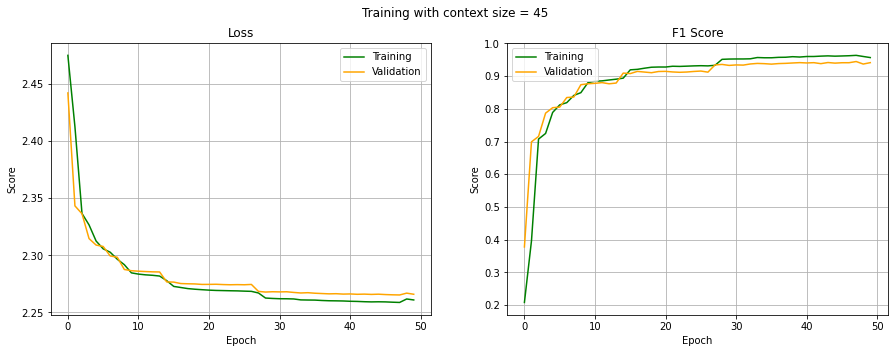

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9605, device='cuda:0'),
 tensor(0.9414, device='cuda:0'),
 tensor(0.9400, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9605, device='cuda:0'),
 tensor(0.9414, device='cuda:0'),
 tensor(0.9400, device='cuda:0'))

## Heatmap

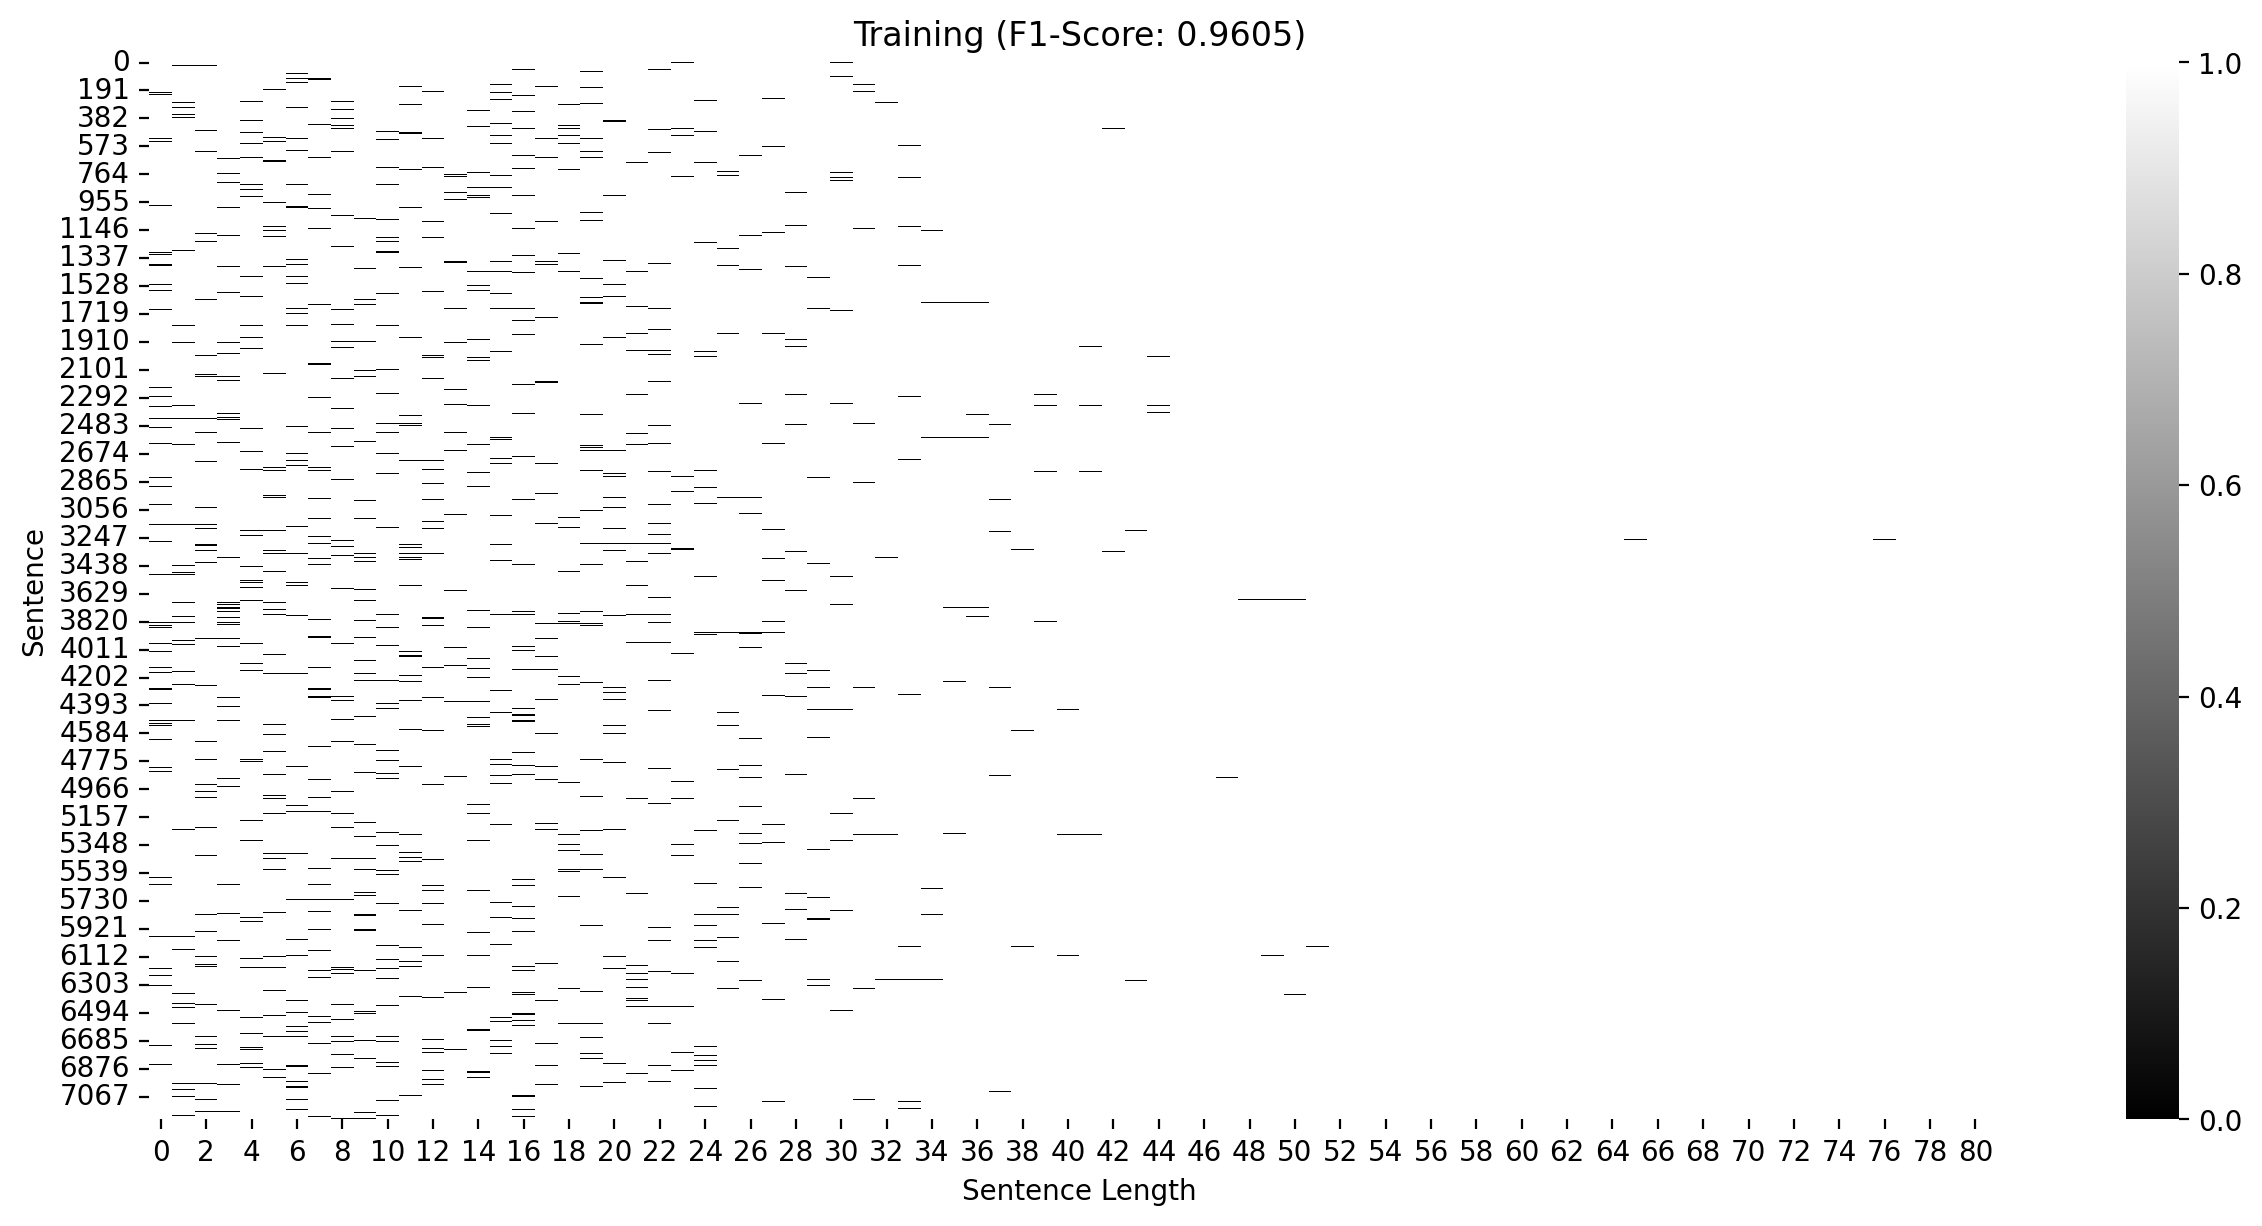

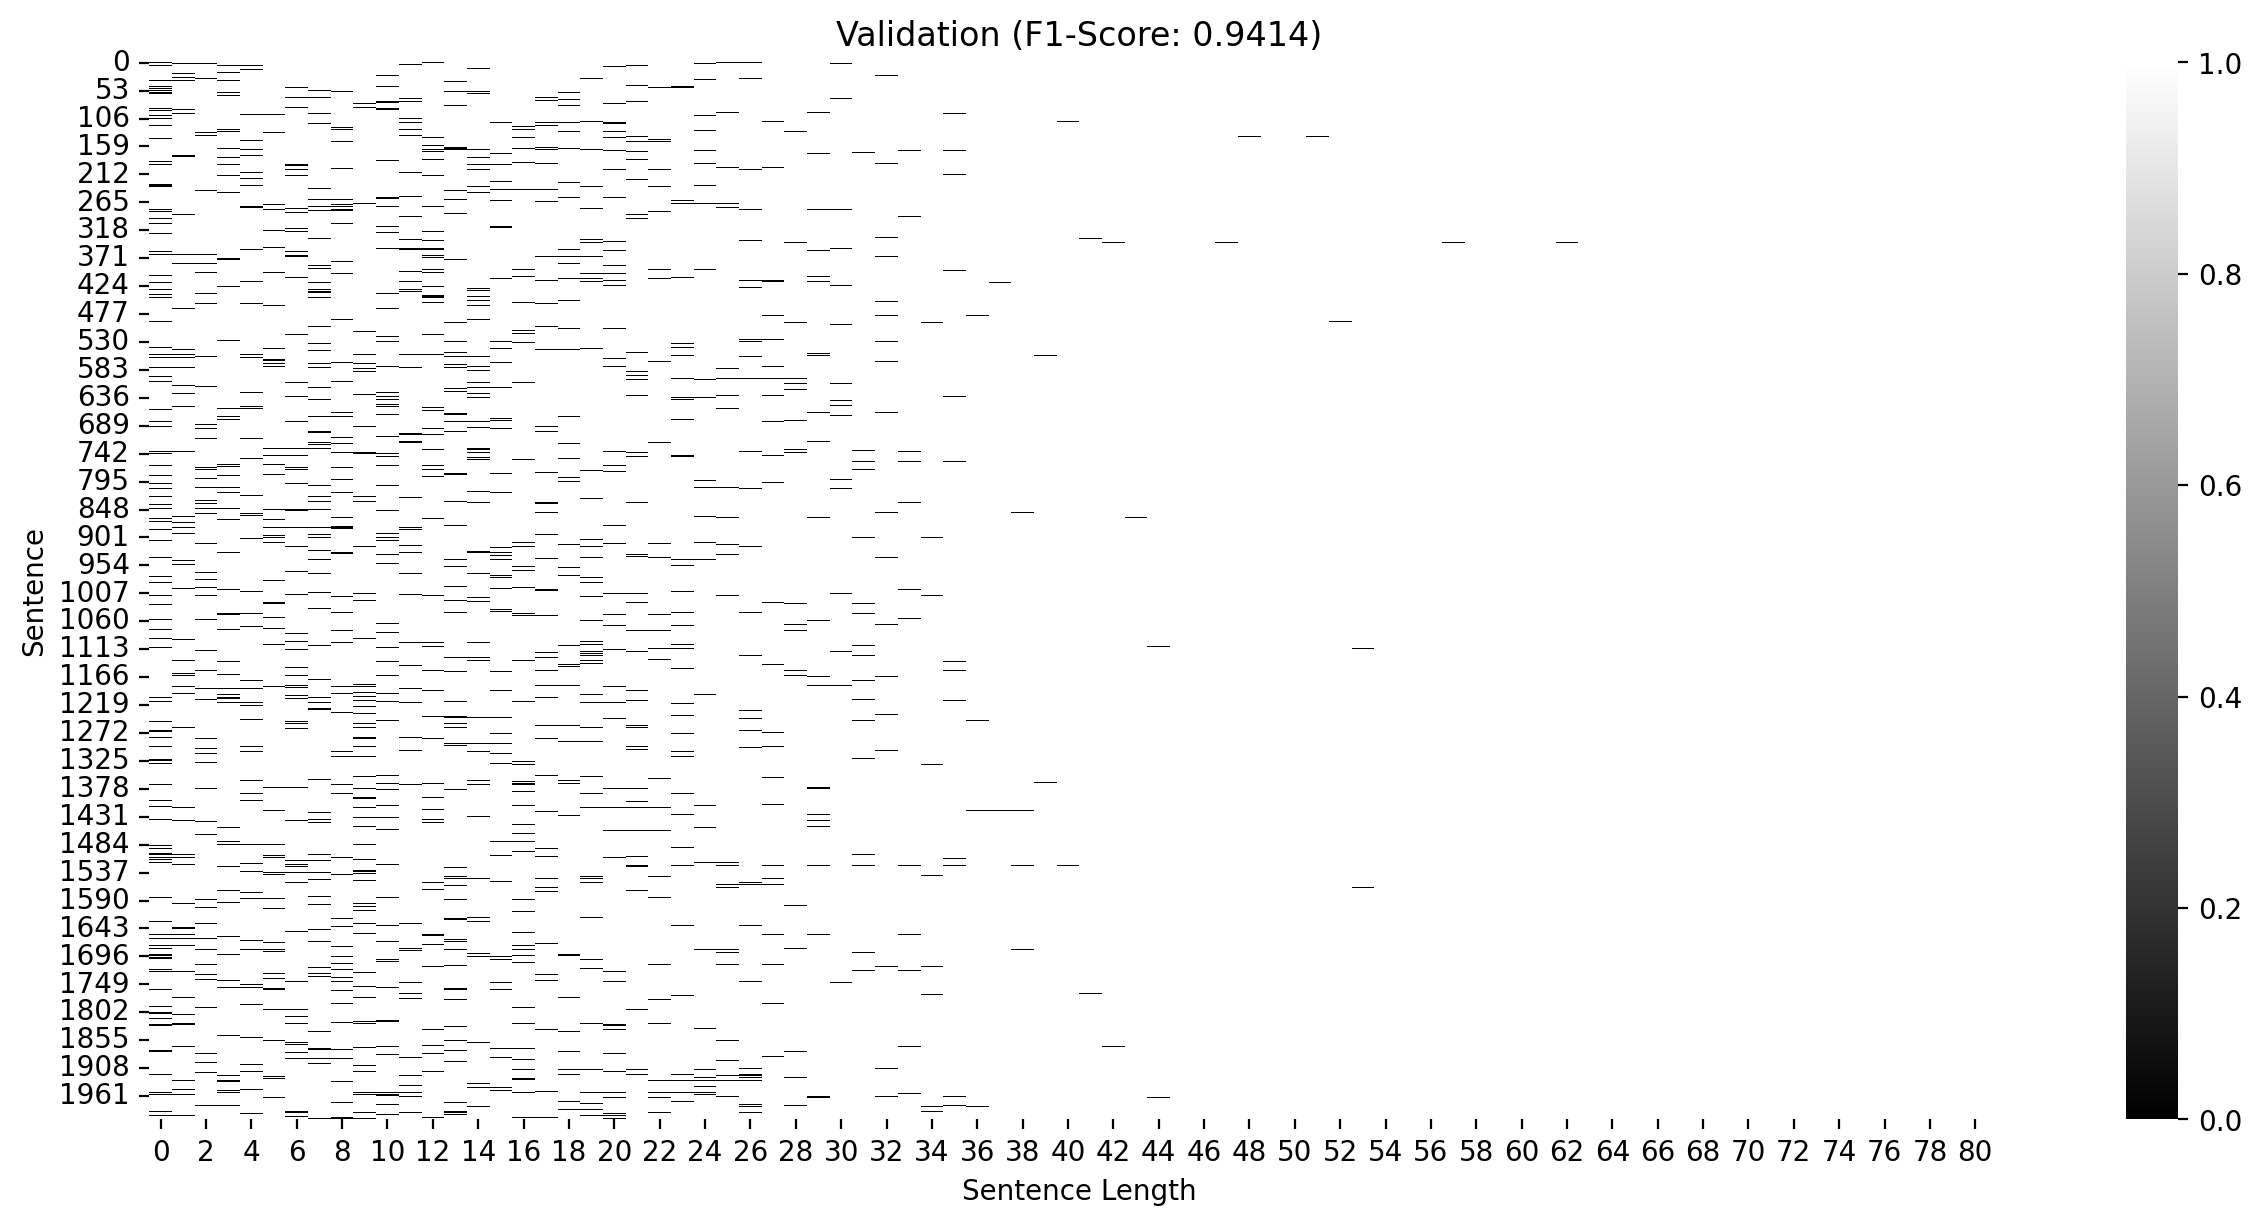

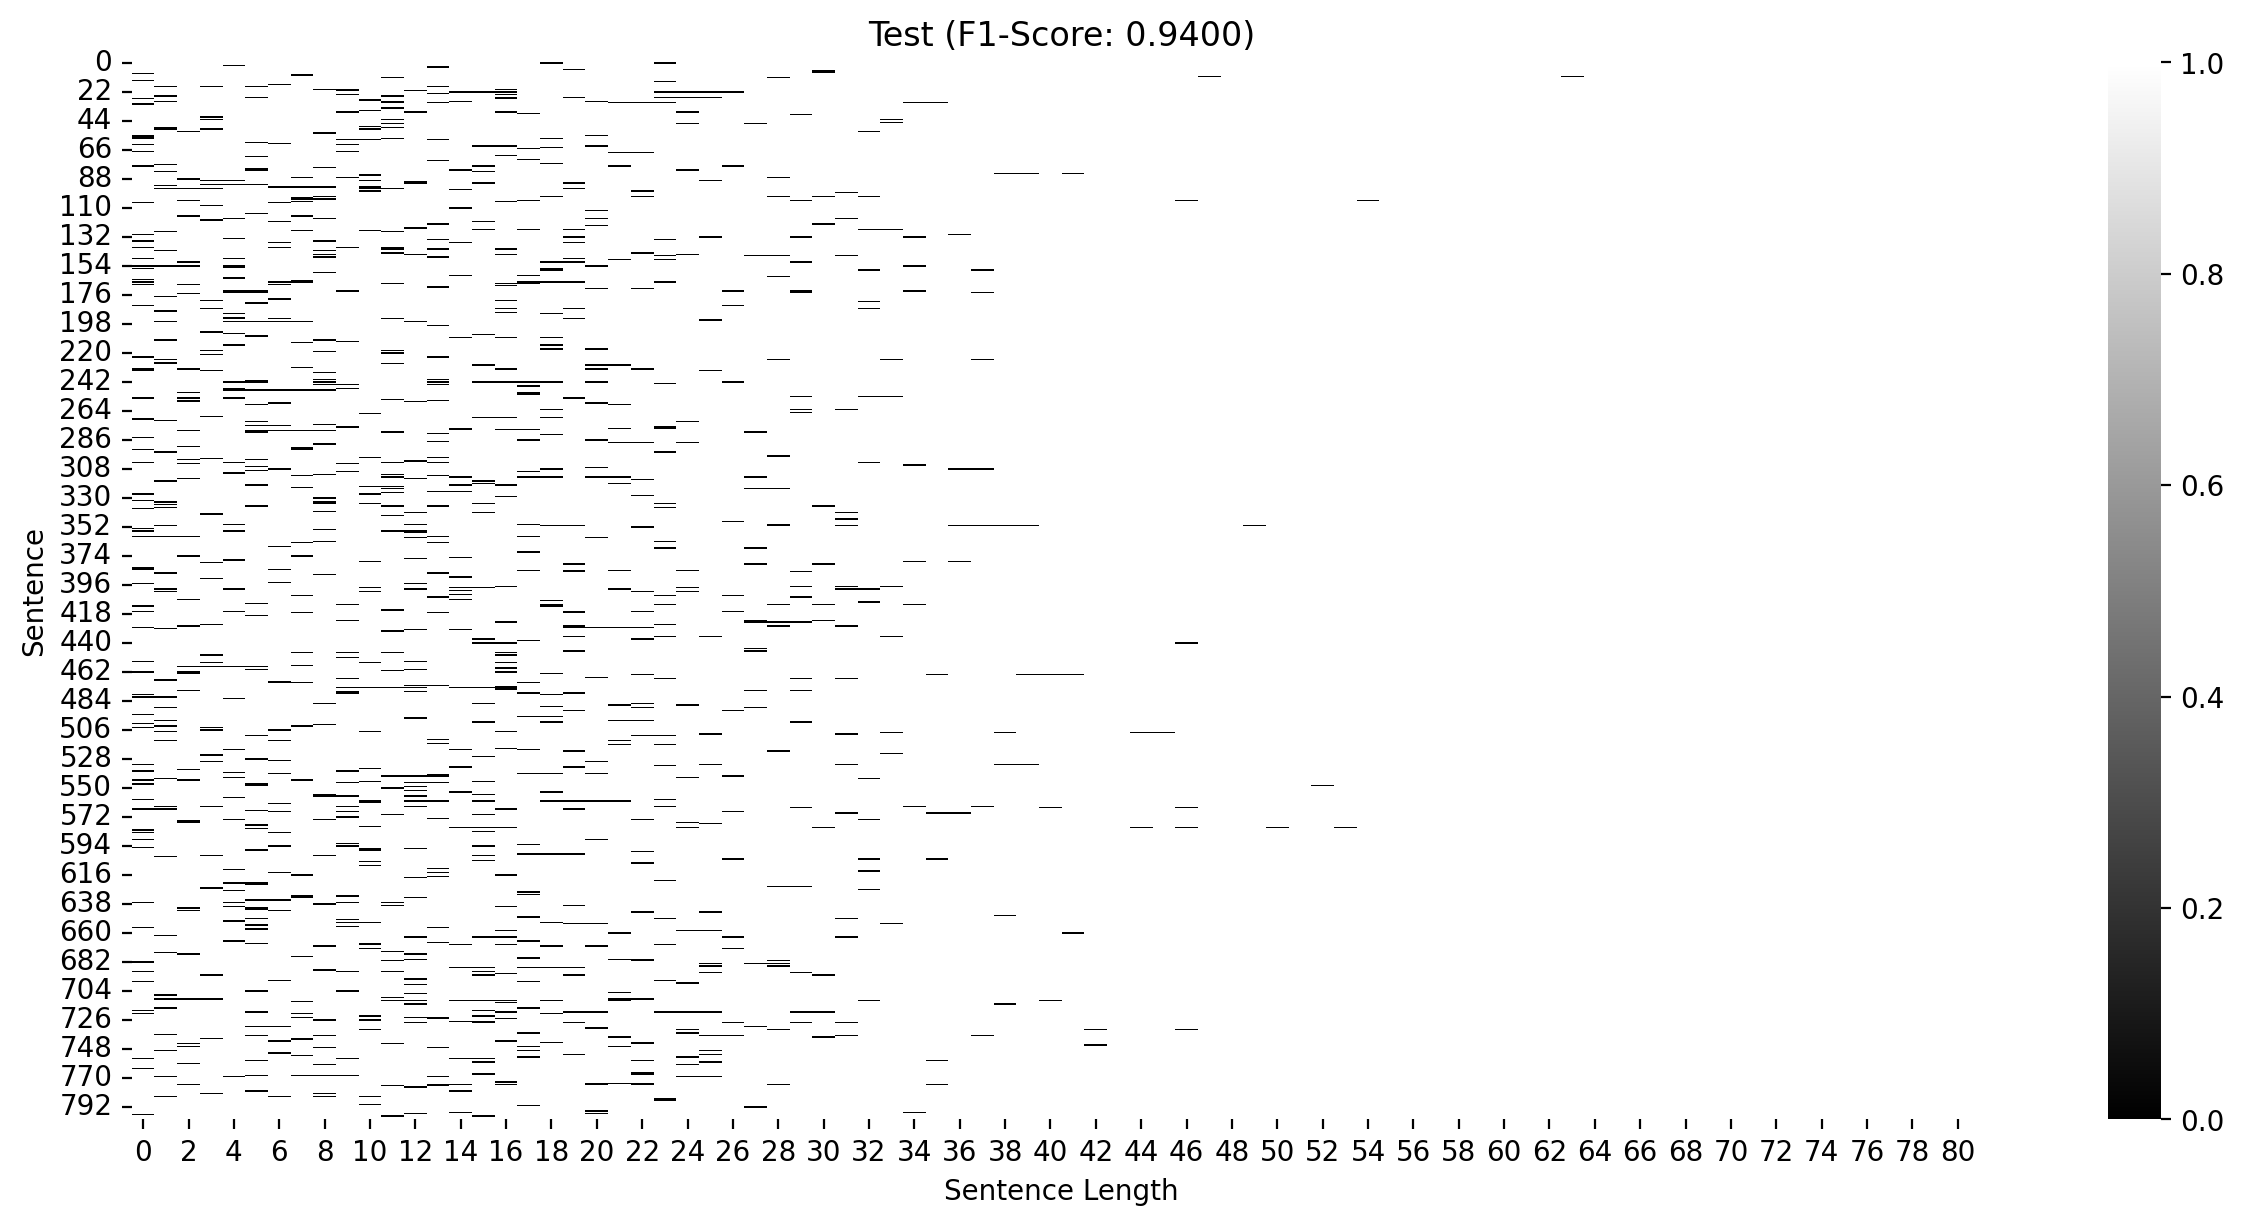

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


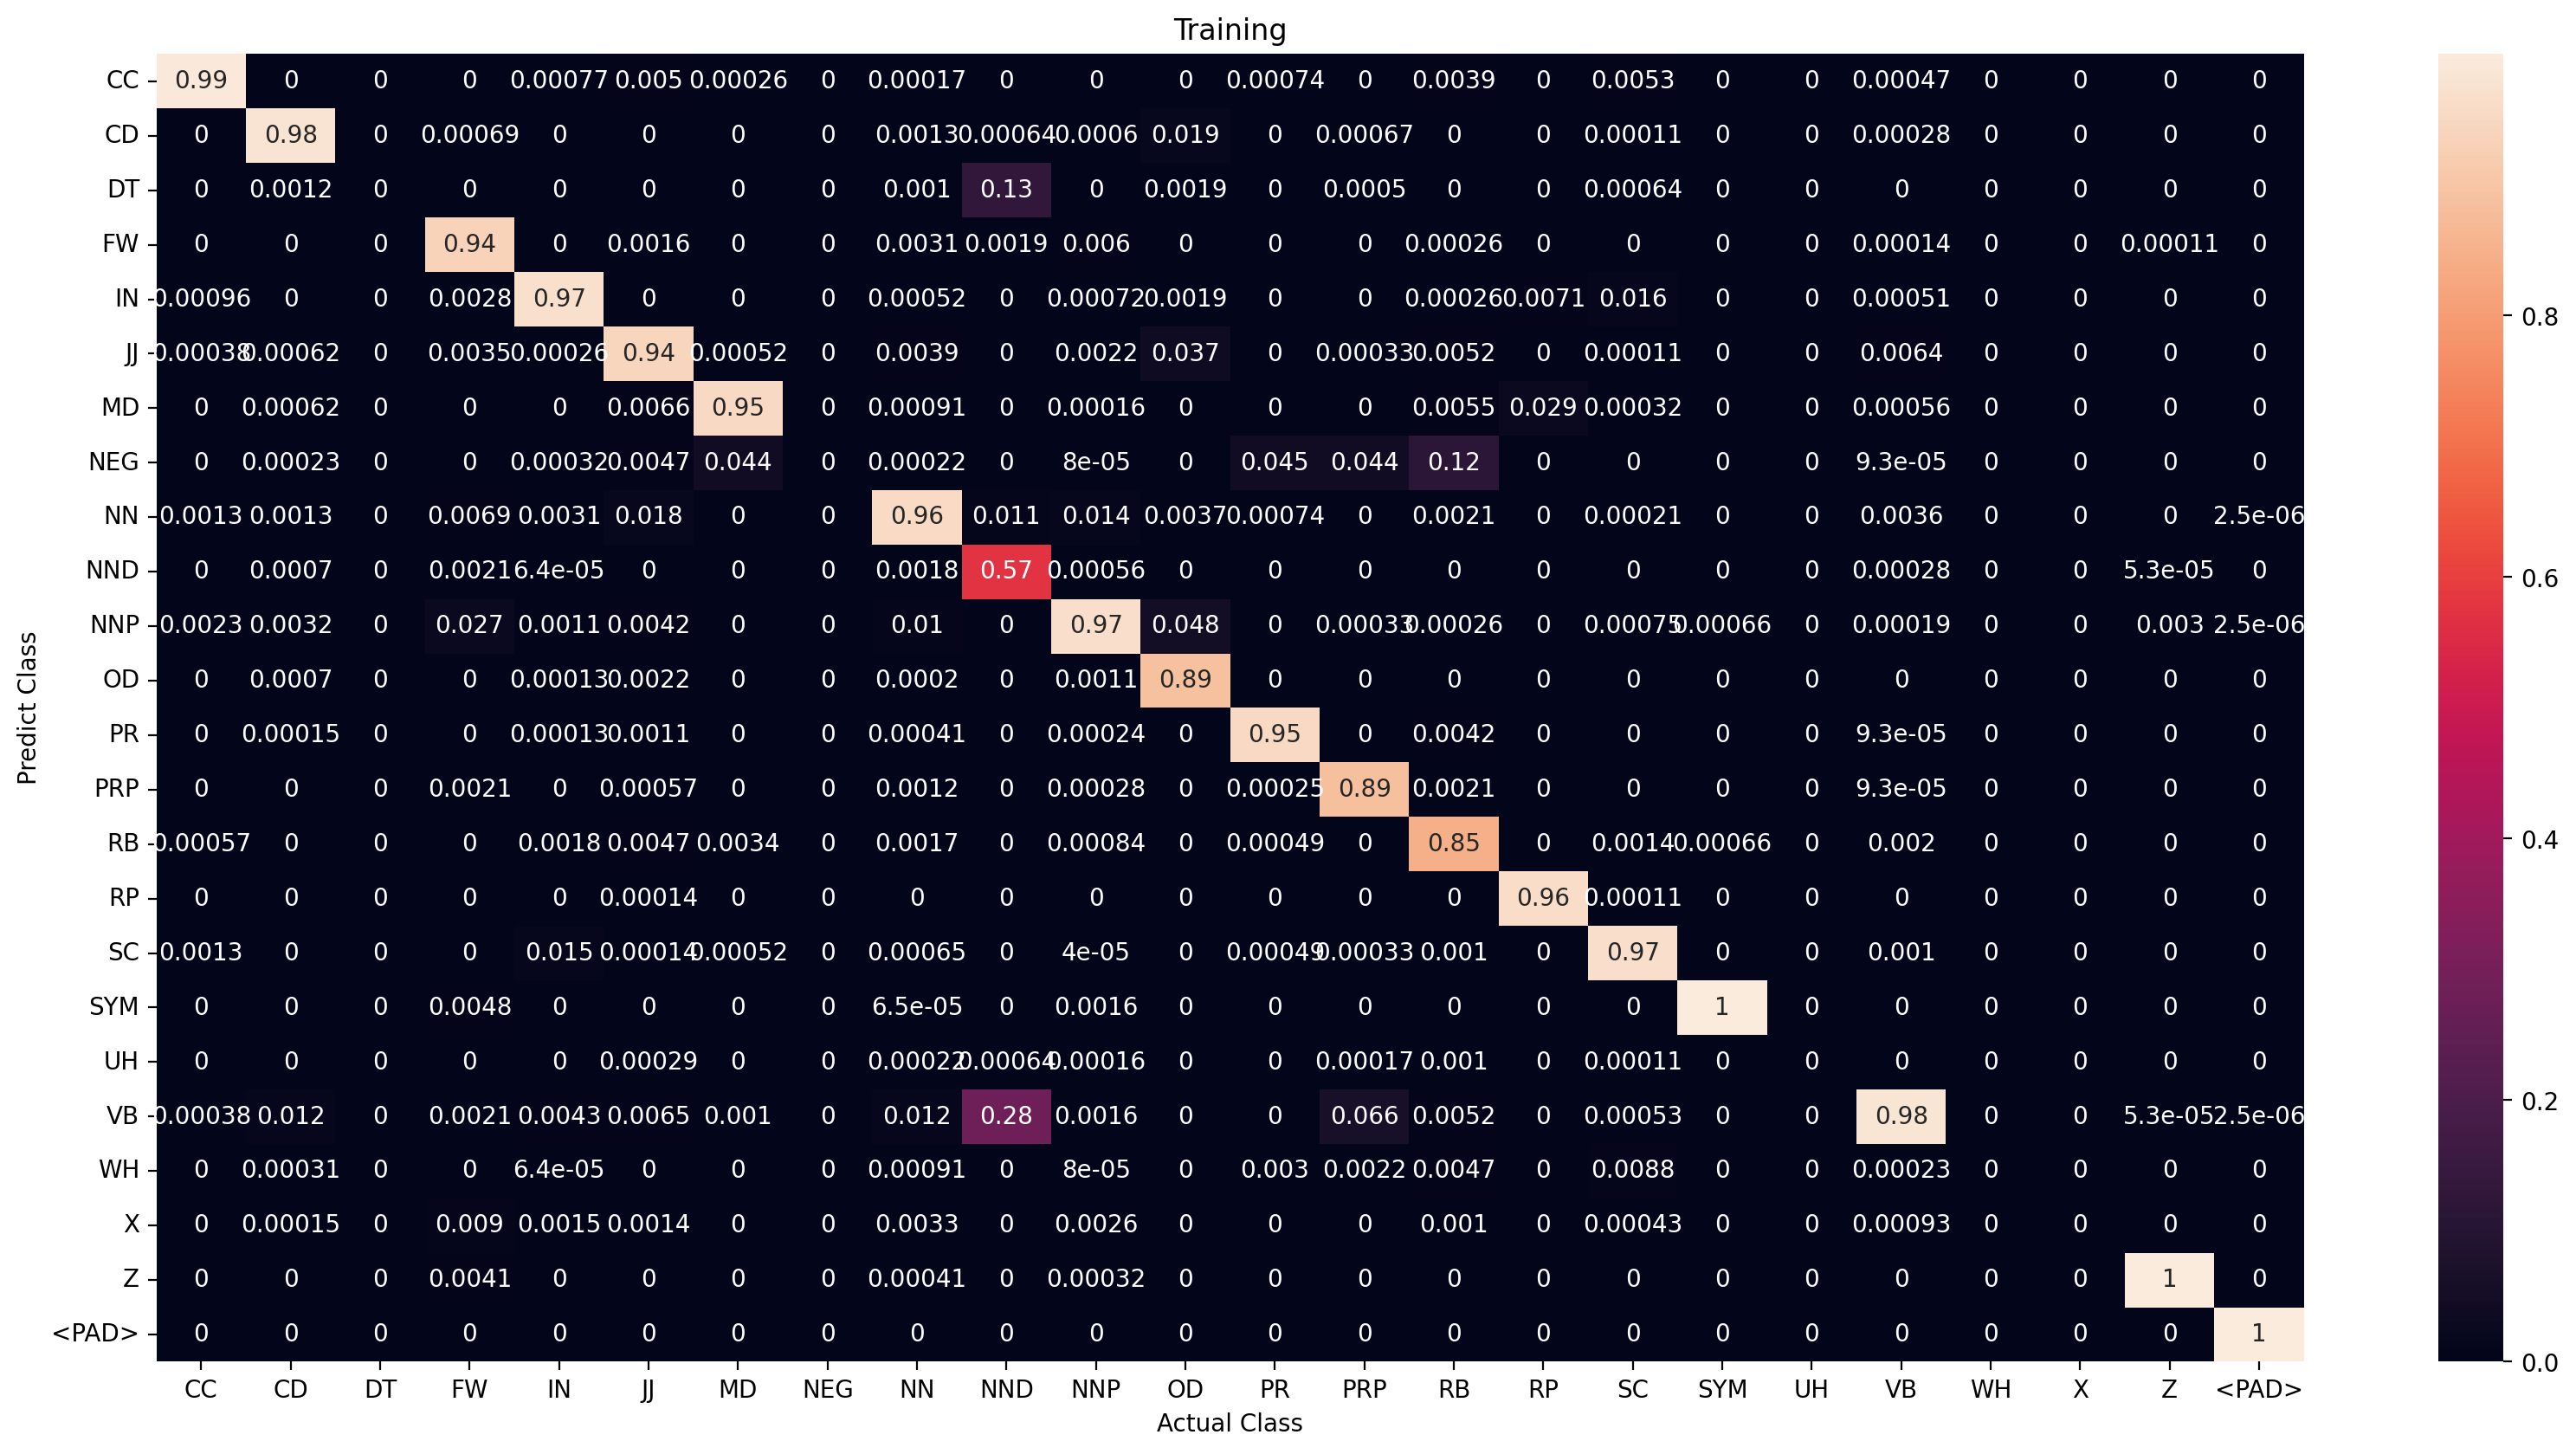

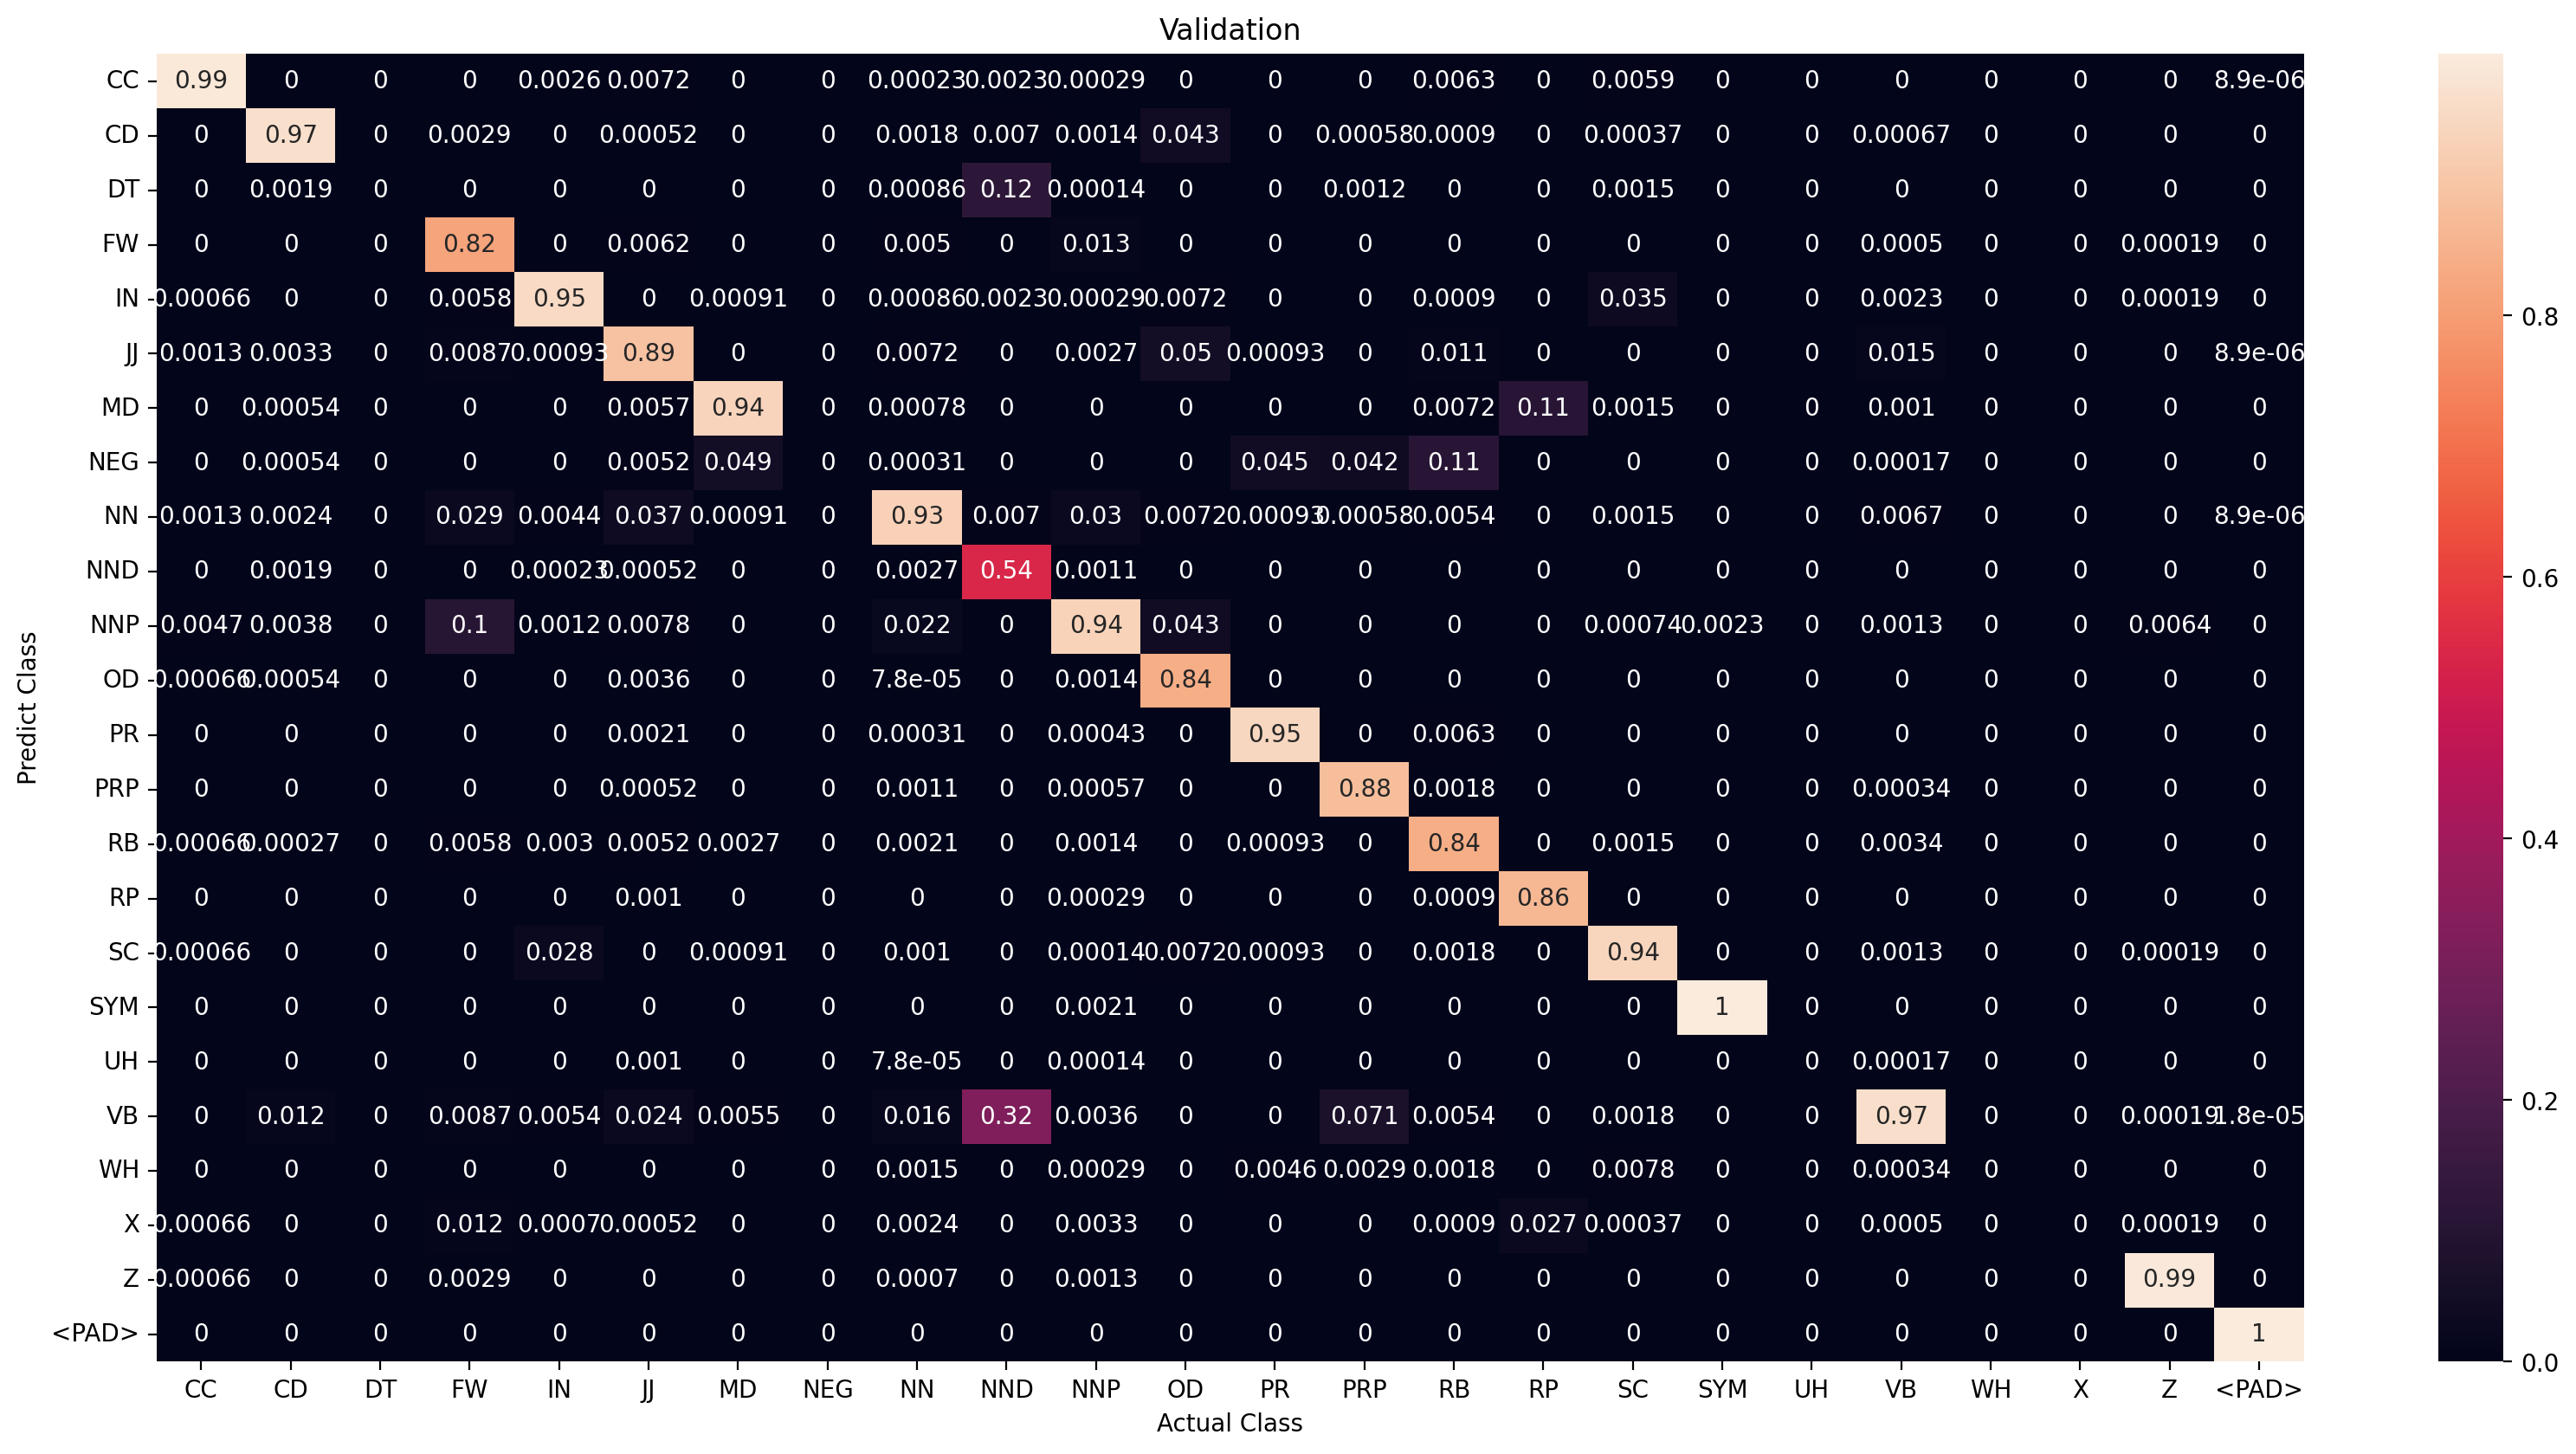

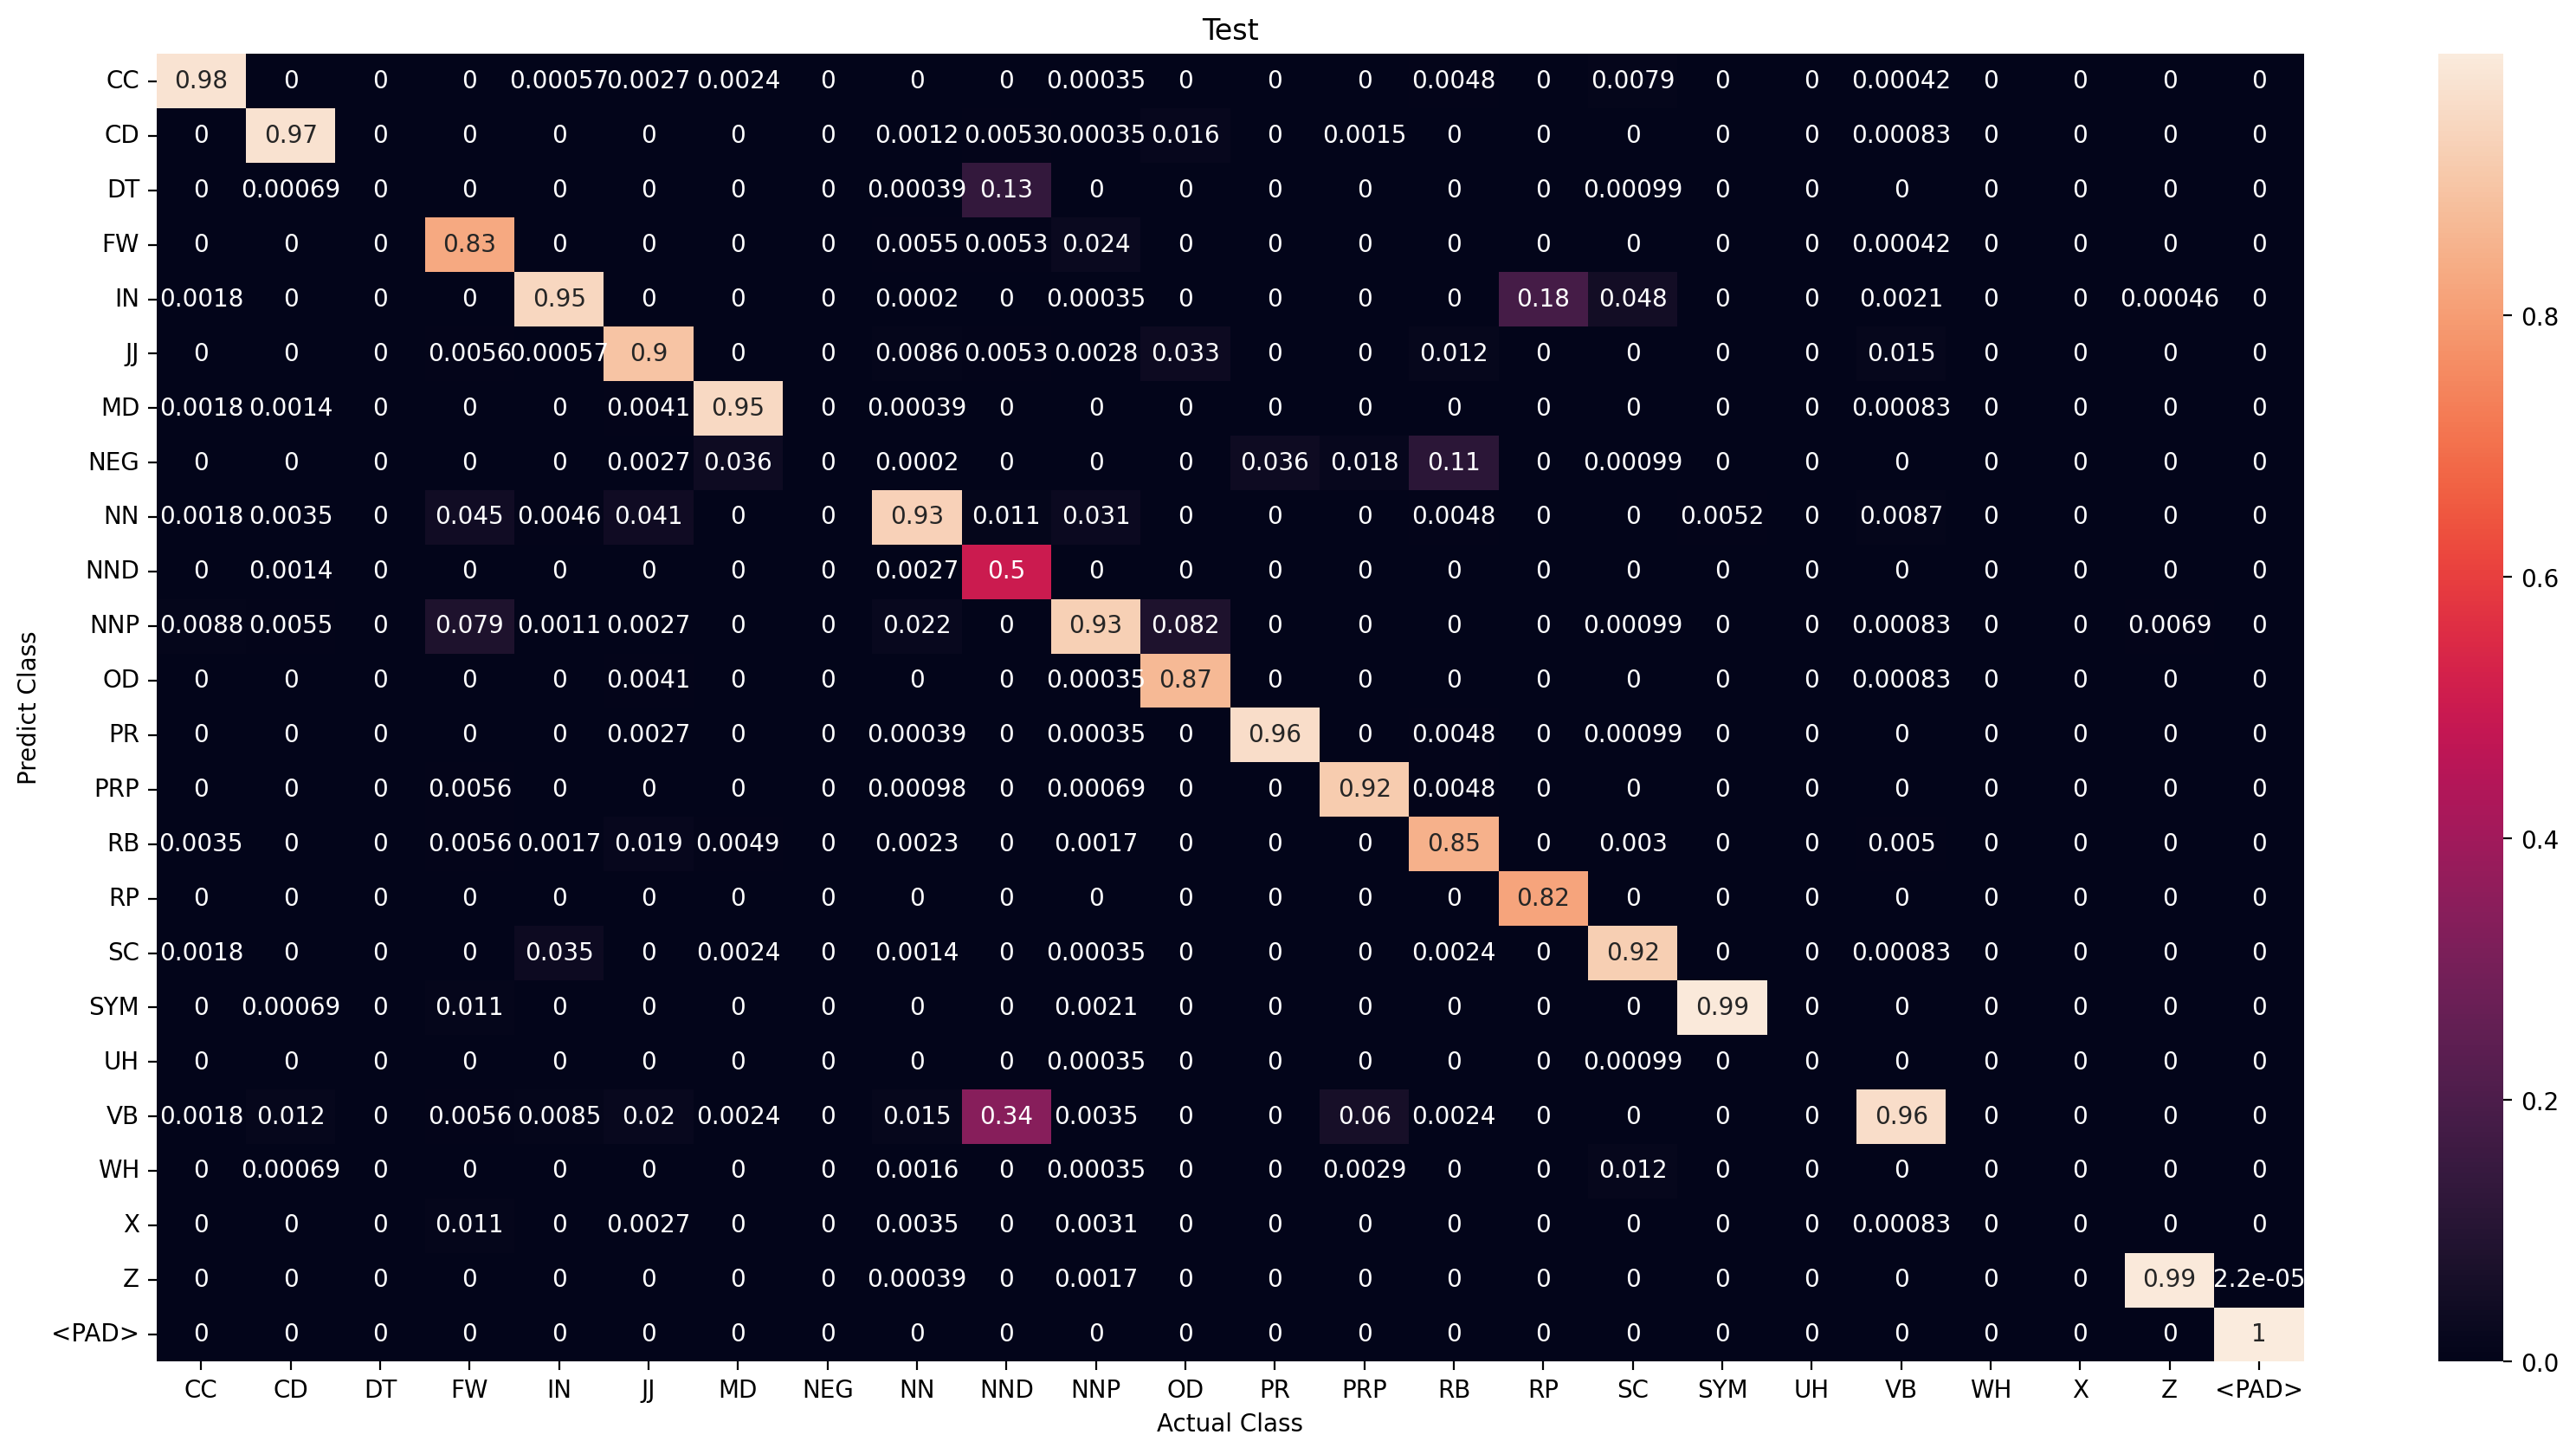

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5322   | CC    : 5188       | CC    : 134      |
| CD    : 12758  | CD    : 12661      | CD    : 97       |
| DT    : 277    | DT    : 0          | DT    : 277      |
| FW    : 1666   | FW    : 1354       | FW    : 312      |
| IN    : 15371  | IN    : 15160      | IN    : 211      |
| JJ    : 6997   | JJ    : 6559       | JJ    : 438      |
| MD    : 3774   | MD    : 3634       | MD    : 140      |
| NEG   : 1113   | NEG   : 0          | NEG   : 1113     |
| NN    : 44672  | NN    : 44001      | NN    : 671      |
| NND   : 1021   | NND   : 902        | NND   : 119      |
| NNP   : 24845  | NNP   : 24131      | NNP   : 714      |
| OD    : 541    | OD    : 478        | OD    : 63       |
| PR    : 3896   | PR    : 3841       | PR    : 55       |
| PRP   : 5408   | PRP   : 5326       | PRP   : 82       |
| RB    : 3463   | RB    : 3228       | RB    : 235      |
| RP    : 137    | RP    : 135        | RP    : 2       

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308].detach().cpu() == train_pred_label[308].detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11821
Correct prediction          : 11107
Wrong prediction            : 714
Percentage correct oov pred : 93.95990186955419

Validation
Number OOV token            : 3350
Correct prediction          : 2970
Wrong prediction            : 380
Percentage correct oov pred : 88.65671641791046

Test
Number OOV token            : 1391
Correct prediction          : 1242
Wrong prediction            : 149
Percentage correct oov pred : 89.2882818116463



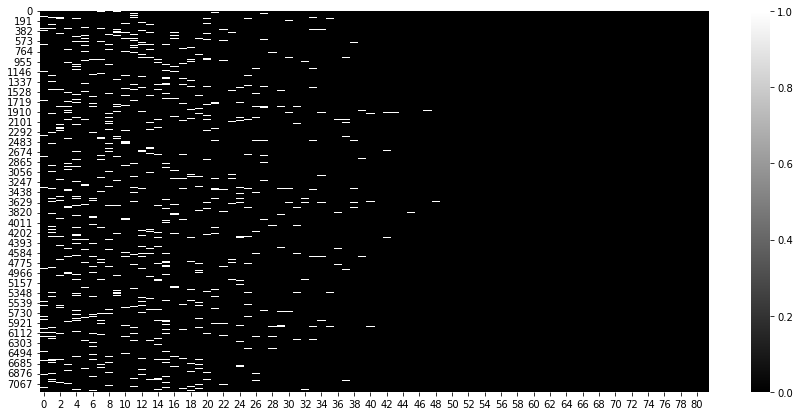

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

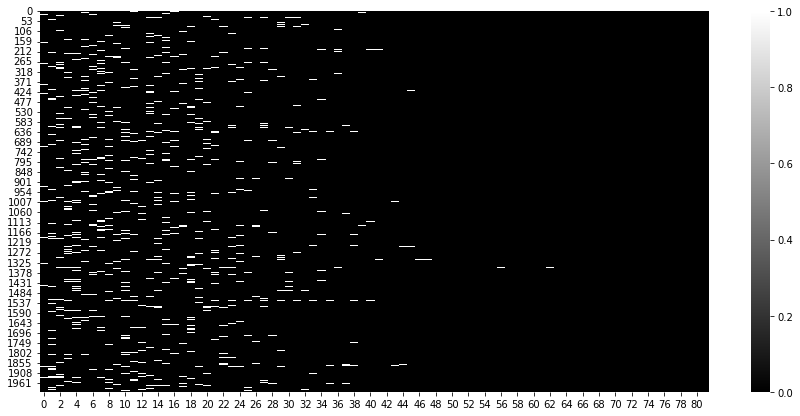

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

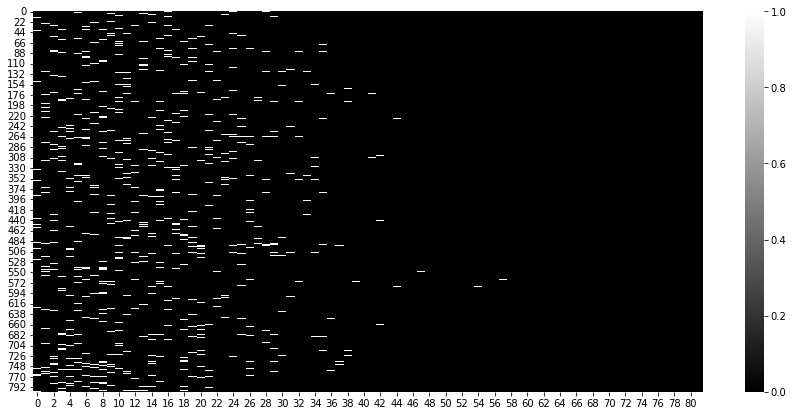

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);